In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import csv
import glob
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import solve_ivp
from ipywidgets import interact, FloatSlider, Layout, interactive
from scipy.optimize import minimize



$\text{If we are given that the molecular weight of the protein is "Z" Da and if we also know that the volume of the droplet is } X \, \mu \text{L}$

$\text{then we can find out the number of protein molecules. We already know from before what the protein concentration is at every time value.}$ 

$\text{The protein concentration will be labeled as "Y". The first step is to find out the mass of the protein at every different time value}$

$\text{Mass of the protein} = \frac{Y\text{ng}}{\mu \text{L}} \times X \, \mu \text{L} = X \, Y \, \text{ng}$

$\text{The second step is to identiy the definition of 1 Da: }$

$1 \, \text{Da} = \frac{1 \, \text{g}}{\text{mol}} = \frac{1 \, \text{ng}}{\text{nmol}}$

$\text{The third step is to calculate the number of protein molecules: }$

$\text{number of protein molecules} = \left( \frac{1 \, \text{nmol}}{Z \, \text{ng}} \right) \left( X \, Y \, \text{ng} \right) \left( 6 \times 10^{14} \, \frac{\text{molecules}}{1 \, \text{nmol}} \right)$

$ = \frac{6 \times 10^{14} XY}{Z}$

where $X$ is the droplet volume in $\mu L$, $Y$ is the protein concentration in $\frac{ng}{\mu L}$, and $Z$ is the atomic weight in $\frac{g}{mol}$




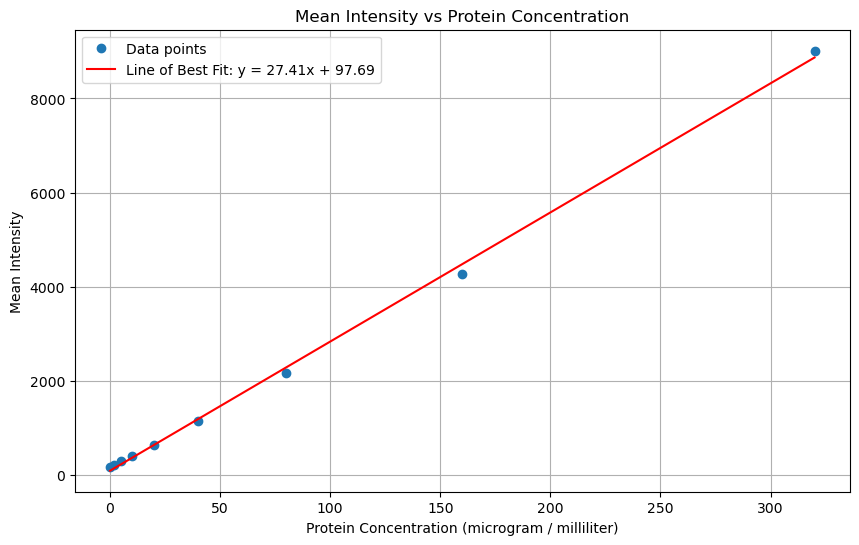

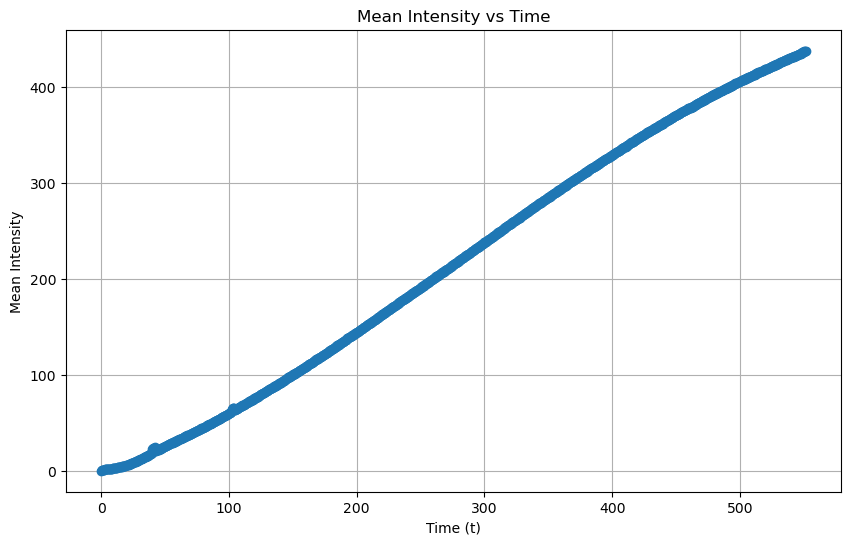

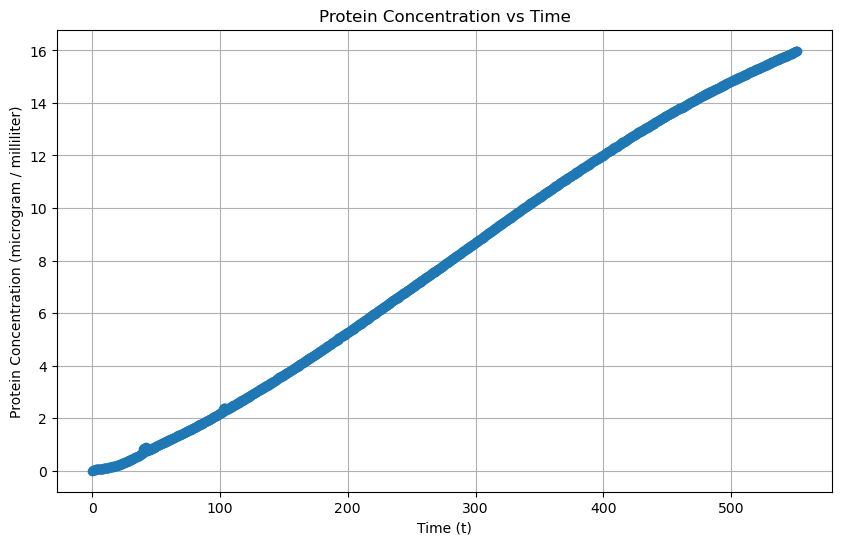

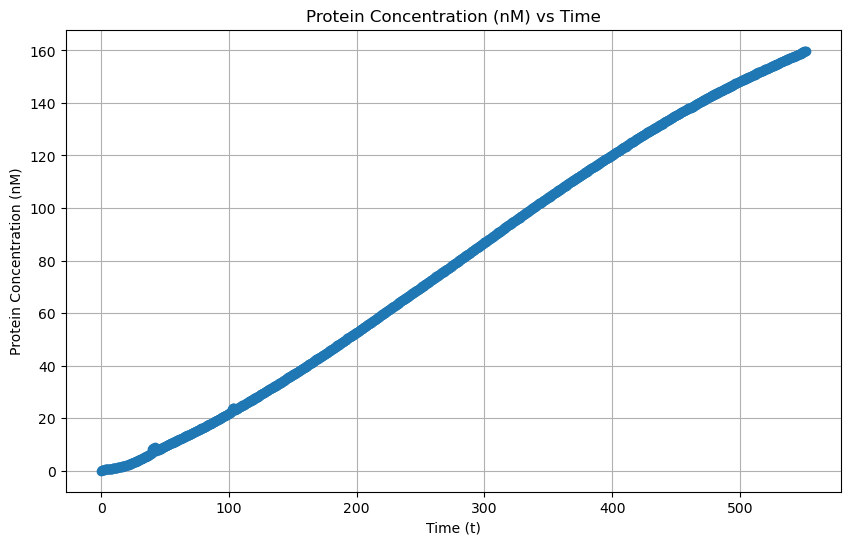

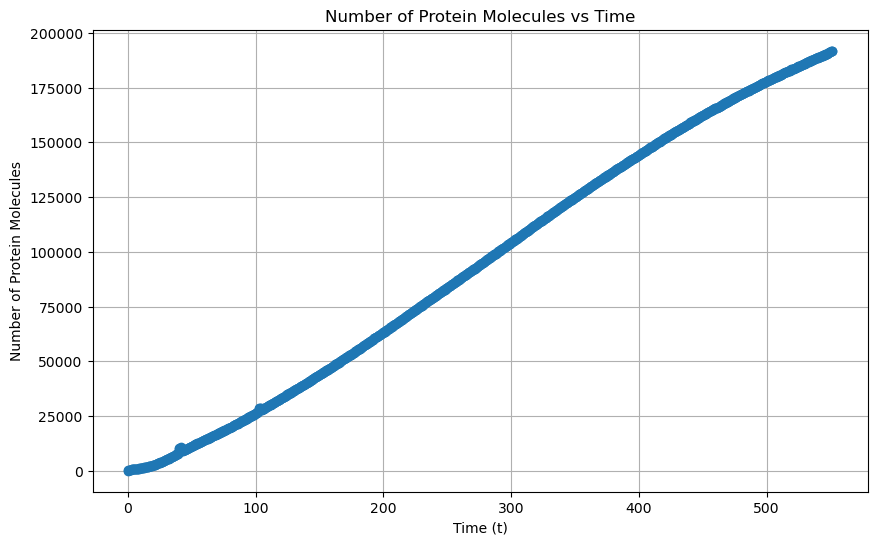

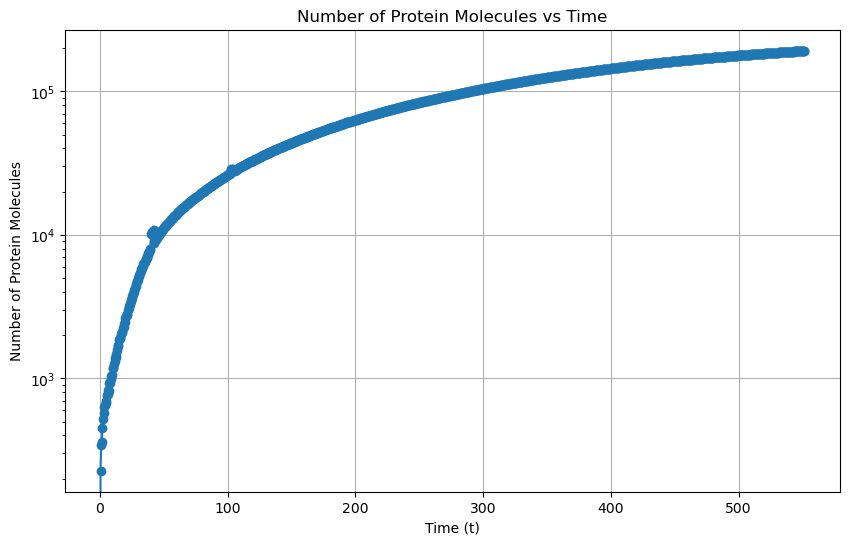

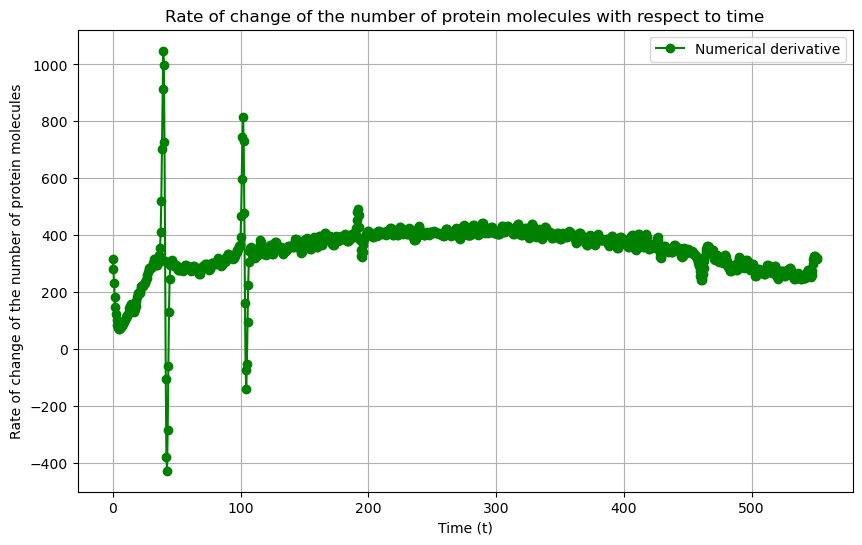

In [3]:

timeValues_List = list()
meanIntensity_List = list()
meanIntensity_CalibrationCurve_List = list()
proteinConcentration_List = list()
proteinConcentration_nM_List = list()
numberOfProteinMolecules_List = list()
rateOfChangeProteinMolecules_List = list()

# This function utilizes the images taken for the experiment of the K401 motor protein
def calculateMeanIntensity(paths):
    for i in range(0, len(paths)): 
        # Load the image as a matrix
        image_path = paths[i]
        image_matrix = io.imread(image_path)
        meanIntensity = image_matrix.mean()
        meanIntensity_List.append(meanIntensity)

# This function utilizes 9 sample images to analyze the relationship between "Mean Intensity" and "Protein Concentration"
def getConcentration(calibrationCurvePaths, mw_kda): # This function takes a list of image paths and molecular weight in kDa as arguments
    for i in range(0, len(calibrationCurvePaths)):
        # Load the image as a matrix
        image_path = calibrationCurvePaths[i]
        image_matrix = io.imread(image_path)
        meanIntensity = image_matrix.mean()
        meanIntensity_CalibrationCurve_List.append(meanIntensity) 

    df = pd.DataFrame(meanIntensity_CalibrationCurve_List).reset_index() # Create a data frame 
    df = df.rename(columns={"index":"Protein Concentration (microgram / milliliter)", 0:"Mean Intensity"})
    sampleConcentration_Values = [0, 2, 5, 10, 20, 40, 80, 160, 320]
    df["Protein Concentration (microgram / milliliter)"] = sampleConcentration_Values

    # Get the equation (linear) of best fit for the Protein Concentration
    x = df["Protein Concentration (microgram / milliliter)"]
    y = df["Mean Intensity"]

    slope, intercept = np.polyfit(x, y, 1) # Multiple return values is allowed in Python
    
    line_of_best_fit = slope * x + intercept
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df["Protein Concentration (microgram / milliliter)"], df["Mean Intensity"], marker='o', linestyle='none', label='Data points')
    plt.plot(x, line_of_best_fit, label=f'Line of Best Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
    plt.title('Mean Intensity vs Protein Concentration')
    plt.xlabel('Protein Concentration (microgram / milliliter)')
    plt.ylabel('Mean Intensity')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Transform the dependent variables
    for i in range(0, len(meanIntensity_List)):
        proteinConcentration = (meanIntensity_List[i] - intercept) / slope
        proteinConcentration_List.append(proteinConcentration)
        proteinConcentration_nM = ((proteinConcentration * 1e-3) / (mw_kda * 1e3)) * 1e9 # Convert to nM
        proteinConcentration_nM_List.append(proteinConcentration_nM)

def constructDataFrames(timeInterval):
    global meanIntensity_List
    global proteinConcentration_List
    global proteinConcentration_nM_List

    minimumIntensityValue = min(meanIntensity_List)
    adjustedMeanIntensity_List = [x - minimumIntensityValue for x in meanIntensity_List] # Subtract the minimum mean intensity value from ALL values
    meanIntensity_List = adjustedMeanIntensity_List

    minimumProteinConcentration = min(proteinConcentration_List)
    adjustedProteinConcentration_List = [x - minimumProteinConcentration for x in proteinConcentration_List]
    proteinConcentration_List = adjustedProteinConcentration_List

    minimumProteinConcentration_nM = min(proteinConcentration_nM_List)
    adjustedProteinConcentration_List_nM = [x - minimumProteinConcentration_nM for x in proteinConcentration_nM_List]
    proteinConcentration_nM_List = adjustedProteinConcentration_List_nM    

    df = pd.DataFrame(meanIntensity_List).reset_index() # Create a data frame 
    df = df.rename(columns={"index":"Time (min)", 0:"Mean Intensity"})
    df["Time (min)"] = df["Time (min)"] * timeInterval # Manipulate the "time" values

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df['Time (min)'], df['Mean Intensity'], marker='o')
    plt.title('Mean Intensity vs Time')
    plt.xlabel('Time (t)')
    plt.ylabel('Mean Intensity')
    plt.grid(True)
    plt.show()

    df2 = pd.DataFrame(proteinConcentration_List).reset_index()
    df2 = df2.rename(columns={"index":"Time (min)", 0:"Protein Concentration (nanogram / microliter)"})
    df2["Time (min)"] = df2["Time (min)"] * timeInterval # Manipulate the "time" values
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df2['Time (min)'], df2['Protein Concentration (nanogram / microliter)'], marker='o')
    plt.title('Protein Concentration vs Time')
    plt.xlabel('Time (t)')
    plt.ylabel('Protein Concentration (microgram / milliliter)')
    plt.grid(True)
    plt.show()

    df3 = pd.DataFrame(proteinConcentration_nM_List).reset_index()
    df3 = df3.rename(columns={"index":"Time (min)", 0:"Protein Concentration (nM)"})
    df3["Time (min)"] = df3["Time (min)"] * timeInterval # Manipulate the "time" values

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df3['Time (min)'], df3['Protein Concentration (nM)'], marker='o')
    plt.title('Protein Concentration (nM) vs Time')
    plt.xlabel('Time (t)')
    plt.ylabel('Protein Concentration (nM)')
    plt.grid(True)
    plt.show()

def getNumberOfProteinMolecules(dropletVolume, timeInterval, mw_kda):
    global numberOfProteinMolecules_List
    proteinMass_List = [i * dropletVolume for i in proteinConcentration_List] # List comprehension technique
    numberOfProteinMolecules_List = [(j * 6e14) / (mw_kda * 1e3) for j in proteinMass_List] # This expression was derived from several intermediate calculations

    df = pd.DataFrame(numberOfProteinMolecules_List).reset_index() # Create a data frame 
    df = df.rename(columns={"index":"Time (min)", 0:"Number of Protein Molecules"})
    df["Time (min)"] = df["Time (min)"] * timeInterval # Manipulate the "time" values

    # Plot the data

    plt.figure(figsize=(10, 6))
    plt.plot(df['Time (min)'], df['Number of Protein Molecules'], marker='o')
    plt.title('Number of Protein Molecules vs Time')
    plt.xlabel('Time (t)')
    plt.ylabel('Number of Protein Molecules')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(df['Time (min)'], df['Number of Protein Molecules'], marker='o')
    plt.title('Number of Protein Molecules vs Time')
    plt.xlabel('Time (t)')
    plt.ylabel('Number of Protein Molecules')
    # y axis log scale
    plt.yscale('log')
    plt.grid(True)
    plt.show()

def getRateOfChangeProteinMolecules(timeInterval):
    global timeValues_List
    global rateOfChangeProteinMolecules_List
    
    p_vals = np.array(numberOfProteinMolecules_List) # Converts a Python list to a numpy array
    length = len(numberOfProteinMolecules_List)
    maxTimeValue = (length - 1) * timeInterval 
    t_vals = np.linspace(0, maxTimeValue, length) # Creates a numpy array
    timeValues_List = t_vals.tolist()

    # Estimate the numerical derivative of the number of protein molecules with respect to time
    dp_dt = np.gradient(p_vals, t_vals)
    rateOfChangeProteinMolecules_List = dp_dt.tolist()

    # apply gaussian filter with sigma 2
    dp_dt = gaussian_filter1d(dp_dt, sigma=2)
    
    # Plot the estimated derivative
    plt.figure(figsize=(10, 6))
    plt.plot(t_vals, dp_dt, label='Numerical derivative', marker='o', color="green")
    plt.xlabel('Time (t)')
    plt.ylabel('Rate of change of the number of protein molecules')
    plt.title('Rate of change of the number of protein molecules with respect to time')
    plt.legend()
    plt.grid(True)
    plt.show()

def saveData(fileName): # Saves the data to a CSV file
    # save dataframes to csv files
    dataFile = open(fileName, 'w', newline="")
    writerCSV = csv.writer(dataFile)
    headerRow = list()
    headerRow.append("Time")
    headerRow.append("Mean Intensity")
    headerRow.append("Protein Concentration (ng/µL)")
    headerRow.append("Protein Concentration (nM)")
    headerRow.append("Number of Protein Molecules (PM)")
    headerRow.append("Rate of Change of Number of PM")
    writerCSV.writerow(headerRow)
    for i in range(0, len(meanIntensity_List)):
        dataRow = list()
        dataRow.append(timeValues_List[i])
        dataRow.append(meanIntensity_List[i])
        dataRow.append(proteinConcentration_List[i])
        dataRow.append(proteinConcentration_nM_List[i])
        dataRow.append(numberOfProteinMolecules_List[i])
        dataRow.append(rateOfChangeProteinMolecules_List[i])
        writerCSV.writerow(dataRow)
    dataFile.close()

def runAnalysis(paths, calibrationCurvePaths, timeInterval, dropletVolume, mw_kda, fileName):
    calculateMeanIntensity(paths) # 1st function to be called
    getConcentration(calibrationCurvePaths, mw_kda) # 2nd function to be called
    constructDataFrames(timeInterval) # Time interval is passed in minutes. # 3th function to be called
    getNumberOfProteinMolecules(dropletVolume, timeInterval, mw_kda) # For the experiment of the K401 protein, the droplet had a volume of 2 microliters. 4th function to be called
    getRateOfChangeProteinMolecules(timeInterval) # 5th function to be called
    saveData(fileName) # 6th function to be called


paths = sorted(glob.glob("/Users/edgarlarios/Dropbox/SURF_activedrops/Edgar/k401-activedrops/img_*********_gfp-4x_000.tif"))
calibration_curve_paths = sorted(glob.glob("/Users/edgarlarios/Dropbox/SURF_activedrops/Edgar/calibration_curve/***ugml.tif"))

# The molecular weight must be passed in kDa, the volume of the droplet must be passed in microliters, and the time interval must be passed in minutes
runAnalysis(paths, calibration_curve_paths, 0.5, 0.000002, 100, "proteinsData.csv") # This is the analysis for the "k401" protein

In [4]:
# plot the raw image as heatmap of fluorescence intensity
def fluorescence_heatmap(data_path, condition, subcondition, channel, time_interval, min_frame, max_frame, vmax, skip_frames=1, line_slope=1, line_intercept=0):
    """
    Reads each image as a matrix, creates and saves a heatmap representing the normalized pixel-wise fluorescence intensity.

    Args:
    - data_path (str): Base directory where the images are stored.
    - condition (str): Condition defining a subdirectory within the data path.
    - subcondition (str): Subcondition defining a further subdirectory.
    - channel (str): Channel specifying the fluorescence ('cy5' or 'gfp').
    - time_interval (int): Time interval in seconds between frames.
    - min_frame (int): Minimum frame number to start processing from.
    - max_frame (int, optional): Maximum frame number to stop processing at.
    """
    # Determine the directory paths based on the channel
    input_directory_path = os.path.join(data_path, condition, subcondition, "original")
    output_directory_path = os.path.join(data_path, condition, subcondition, f"intensity_heatmap_{channel}")
    
    # Create the output directory if it doesn't exist but also deletes the directory if it already exists to start fresh
    if os.path.exists(output_directory_path):
        shutil.rmtree(output_directory_path)
    os.makedirs(output_directory_path, exist_ok=True)


    # Get all .tif files in the folder
    image_files = sorted(glob.glob(os.path.join(input_directory_path, "*.tif")))[min_frame:max_frame:skip_frames] 

    if channel == "cy5":
        image_files = sorted(glob.glob(os.path.join(input_directory_path, "cy5.tif")))[min_frame:max_frame:skip_frames]
    elif channel == "gfp":
        image_files = sorted(glob.glob(os.path.join(input_directory_path, "gfp.tif")))[min_frame:max_frame:skip_frames]
            
    # # Calibration curve parameters
    # line_slope = 0.0004203353275461814
    # line_intercept = 0.0015873751623883166
    y = 0.0004203353275461814 * x + 0.0015873751623883166
    # Loop through each image file and create a heatmap
    for i, image_file in enumerate(image_files, start=min_frame):
        # Read the image into a numpy array
        intensity_matrix = imageio.imread(image_file) / 2**16  # Normalize the 16-bit image to 1.0

        # Convert intensity values to protein concentration using the calibration curve
        concentration_matrix = (intensity_matrix - line_intercept) / line_slope

        # Plot the heatmap
        fig, ax = plt.subplots(figsize=(12, 12))
        im = ax.imshow(concentration_matrix, cmap='gray', interpolation='nearest', extent=[-2762/2, 2762/2, -2762/2, 2762/2], vmin=0, vmax=vmax)
        
        plt.colorbar(im, ax=ax, label='Protein concentration (ng/µl)')
        plt.title(f"Time (min): {(i - min_frame) * time_interval * skip_frames / 60:.2f} \nTime (hours): {(i - min_frame) * time_interval * skip_frames / 3600:.2f} \n{condition} - {subcondition} - {channel}", fontsize=14)
        plt.xlabel('x [µm]')
        plt.ylabel('y [µm]')
        
        # Save the heatmap
        heatmap_filename = f"heatmap_frame_{i}.tif"
        heatmap_path = os.path.join(output_directory_path, heatmap_filename)
        plt.savefig(heatmap_path, bbox_inches='tight', pad_inches=0.1, dpi=300)
        plt.close(fig)


# create a movie from the processed images -- general function
def create_movies(data_path, condition, subcondition, channel, movie_type, frame_rate, feature_limits=None, max_frame=None):
    """
    Creates video files from processed and annotated images stored in a specified directory.

    Args:
    - data_path (str): Base path where the annotated images are stored.
    - condition (str): Condition under which the annotated images are stored.
    - subcondition (str): Subcondition under which the annotated images are stored.
    - channel (str): The specific channel being processed ('cy5' or 'gfp').
    - movie_type (str): Type of movie to create ('single', 'grid', or 'PIV').
    - feature_limits (dict, optional): Dictionary specifying the limits for each feature (only for 'PIV' movie type).
    - frame_rate (int, optional): Frame rate for the output video. Defaults to 120.
    - max_frame (int, optional): Maximum number of frames to be included in the video. If None, all frames are included.
    """

    if movie_type == 'single':
        output_dir = os.path.join(data_path, f"single_movies_{channel}")
        os.makedirs(output_dir, exist_ok=True)
        images_dir = os.path.join(data_path, condition, subcondition, f"intensity_heatmap_{channel}")
        image_files = natsorted(glob.glob(os.path.join(images_dir, "*.tif")))
        out_path = os.path.join(output_dir, f"{condition}_{subcondition}-{channel}.avi")
    elif movie_type == 'grid':
        images_dir = os.path.join(data_path, f"grid_heatmaps_{channel}")
        image_files = natsorted(glob.glob(os.path.join(images_dir, "*.png")))
        out_path = os.path.join(data_path, f"grid-{channel}.avi")
    elif movie_type == 'PIV':
        plots_dir = f"{data_path}/{condition}/{subcondition}/heatmaps_PIV/"
        for feature in feature_limits.keys():
            feature_name_for_file = feature.split()[0]
            heatmap_dir = os.path.join(data_path, condition, subcondition, "heatmaps_PIV", f"{feature.split()[0]}", f"{feature.split()[0]}heatmap**.jpg")
            image_files = natsorted(glob.glob(heatmap_dir))

            if not image_files:
                continue

            # Limit the number of files if max_frame is specified
            image_files = image_files[:max_frame] if max_frame is not None else image_files

            # Get the resolution of the first image (assuming all images are the same size)
            first_image = cv2.imread(image_files[0])
            video_resolution = (first_image.shape[1], first_image.shape[0])  # Width x Height

            # Define the codec and create VideoWriter object
            fourcc = cv2.VideoWriter_fourcc(*'MJPG')
            out = cv2.VideoWriter(f'{plots_dir}{feature_name_for_file}.avi', fourcc, frame_rate, video_resolution)

            for file in image_files:
                img = cv2.imread(file)
                out.write(img)  # Write the image as is, without resizing

            out.release()
        return

    if not image_files:
        print("No images found for video creation.")
        return

    # Limit the number of files if max_frame is specified
    image_files = image_files[:max_frame] if max_frame is not None else image_files

    # Get the resolution of the first image (assuming all images are the same size)
    first_image = cv2.imread(image_files[0])
    video_resolution = (first_image.shape[1], first_image.shape[0])  # Width x Height

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out = cv2.VideoWriter(out_path, fourcc, frame_rate, video_resolution)

    for file_path in image_files:
        img = cv2.imread(file_path)
        out.write(img)  # Write the image frame to the video

    out.release()
    print(f"Video saved to {out_path}")

# generate movies from individual fluorescence intensity heatmaps
def single_fluorescence_movies(data_path, conditions, subconditions, channel, time_intervals, min_frame, max_frame, vmax, skip_frames, frame_rate, line_slope=1, line_intercept=0):
    for i, condition in enumerate(conditions):
        time_interval = time_intervals[i]
        for subcondition in subconditions:
            # Create heatmaps for each condition and subcondition
            fluorescence_heatmap(
                data_path=data_path,
                condition=condition,
                subcondition=subcondition,
                channel=channel,
                time_interval=time_interval,
                min_frame=min_frame,
                max_frame=max_frame,
                vmax=vmax,
                skip_frames=skip_frames,
                line_intercept=line_intercept,
                line_slope=line_slope
            )

            # Create annotated image movies for each condition and subcondition
            create_movies(
                data_path=data_path,
                condition=condition,
                subcondition=subcondition,
                channel=channel,
                movie_type='single',
                frame_rate=frame_rate,
                max_frame=max_frame
            )

# combine all the movies into a single movie (heatmaps in a grid)
def grid_heatmaps(data_path, conditions, subconditions, channel, frame_rate, figsize):
    output_dir = os.path.join(data_path, f"grid_heatmaps_{channel}")
    os.makedirs(output_dir, exist_ok=True)
    
    # Collect all image paths for the specified channel across all conditions and subconditions
    all_image_paths = []
    for condition in conditions:
        for subcondition in subconditions:
            image_dir = os.path.join(data_path, condition, subcondition, f"intensity_heatmap_{channel}")
            image_paths = natsorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')])
            all_image_paths.extend(image_paths)
    
    # Number of frames is based on the unique frames across all conditions and subconditions
    num_frames = len(set(os.path.basename(path) for path in all_image_paths))
    
    # Iterate over the number of unique frames
    for frame_idx in range(0, num_frames):
        fig, ax = plt.subplots(len(subconditions), len(conditions), figsize=figsize)
        
        for i, subcondition in enumerate(subconditions):
            for j, condition in enumerate(conditions):
                # Construct the path for the current heatmap for each condition and subcondition
                image_path = os.path.join(data_path, condition, subcondition, f"intensity_heatmap_{channel}", f"heatmap_frame_{frame_idx}.tif")
                
                # Ensure the file exists before attempting to read it
                if os.path.exists(image_path):
                    im = imageio.imread(image_path)
                    ax[i, j].imshow(im, cmap='gray')
                    ax[i, j].axis('off')
                else:
                    # Handle missing files (optional) by clearing or placing a placeholder
                    ax[i, j].axis('off')
        
        plt.subplots_adjust(wspace=0, hspace=0)
        output_path = os.path.join(output_dir, f"heatmap_grid_frame_{frame_idx}.png")
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1, dpi=250)
        plt.close(fig)

    create_movies(data_path, condition=None, subcondition=None, channel=channel, movie_type='grid', frame_rate=frame_rate)

# Comprehensive Guide to Cell-Free Protein Synthesis Model

## 1. Biological Background

In cell-free protein synthesis systems, we study the processes of transcription and translation outside of living cells. This allows us to examine these processes in a more controlled environment. The key components are:

1. DNA: The template for transcription
2. RNA Polymerase: Enzyme that transcribes DNA into mRNA
3. mRNA: The product of transcription and template for translation
4. Ribosomes: Molecular machines that translate mRNA into proteins
5. Amino Acids: Building blocks of proteins
6. Proteases: Enzymes that degrade proteins

The process flows as follows: DNA → mRNA → Protein, with protein degradation occurring simultaneously.

## 1. Model Parameters

- $k_{TX}$: Transcription rate [nucleotides/second]
- $k_{TL}$: Translation rate [amino acids/second]
- $N_m$: mRNA length [nucleotides]
- $N_p$: Protein length [amino acids]
- $\tau_m$: mRNA lifetime [seconds]
- $\tau_0$: Transcription delay [seconds]
- $\tau_f$: Protein folding delay [seconds]
- $R_p$: RNA polymerase concentration [nM]
- $R$: Ribosome concentration [nM]
- $K_{TL}$: Michaelis-Menten constant for translation [nM]
- $D$: DNA concentration [nM]
- $k_{deg}$: Protein degradation rate constant [1/second]
- $X_p$: Protease concentration [nM]
- $K_p$: Michaelis-Menten constant for degradation [nM]

## 2. Mathematical Model

### 2.1 mRNA Dynamics

The rate of change of mRNA concentration is given by:

$\frac{dm}{dt} = k_{TX}N_m^{-1}[R_p]D - \frac{m(t)}{\tau_m}, \quad \forall t > \tau_0$

#### Dimensional Analysis:
- $\frac{dm}{dt}$: [nM]/[s]
- $k_{TX}N_m^{-1}[R_p]D$: ([nt]/[s]) · (1/[nt]) · [nM] · [nM] = [nM]/[s]
- $\frac{m(t)}{\tau_m}$: [nM]/[s]

#### Solution:
Solving this differential equation (see mathematical steps in section 4), we get:

$$m(t) = m_{ss}(1 - e^{-(t - \tau_0)/\tau_m}), \quad \forall t > \tau_0$$

Where $m_{ss}$ is the steady-state mRNA concentration:

$$m_{ss} = k_{TX}N_m^{-1}[R_p]D\tau_m$$

### 3.2 Protein Synthesis


#### Dimensional Analysis:

$\frac{dp_{syn}}{dt} = \frac{k_{TL}N_p^{-1}}{1 + K_{TL}/R}m(t - \tau_f)$
$\text{, where}$ $\frac{dp_{syn}}{dt}$ $\text{represents the rate of change of protein synthesis}$

- $\frac{dp_{syn}}{dt}$: [nM]/[s]
- $\frac{k_{TL}N_p^{-1}}{1 + K_{TL}/R}m(t - \tau_f)$: ([aa]/[s]) · (1/[aa]) · [dimensionless] · [nM] = [nM]/[s]

### 3.3 Protein Degradation

The rate of protein degradation follows Michaelis-Menten kinetics:



#### Dimensional Analysis:

$\frac{dp_{deg}}{dt} = -\frac{k_{deg}[p]X_p}{K_p + [p]}$
$\text{, where}$ $\frac{dp_{deg}}{dt}$ $\text{represents the rate of change of protein degradation}$

- $\frac{dp_{deg}}{dt}$: [nM]/[s]
- $\frac{k_{deg}[p]X_p}{K_p + [p]}$: [1/s] · [nM] · [nM] / [nM] = [nM]/[s]

### 2.2 Protein Dynamics

The rate of change of protein concentration is given by:

$\frac{dp}{dt} = \frac{k_{TL}N_p^{-1}}{1 + K_{TL}/R}m(t - \tau_f) - \frac{k_{deg}[p]X_p}{K_p + [p]}$

## 4. Mathematical Steps

### Solving the mRNA dynamics equation:

1) Start with: $\frac{dm}{dt} = k_{TX}N_m^{-1}[R_p]D - \frac{m(t)}{\tau_m}$

2) Let $a = k_{TX}N_m^{-1}[R_p]D$ for simplicity: $\frac{dm}{dt} = a - \frac{m(t)}{\tau_m}$

3) Rearrange: $\frac{dm}{dt} + \frac{m(t)}{\tau_m} = a$

4) Multiply by integrating factor $e^{t/\tau_m}$: $e^{t/\tau_m}\frac{dm}{dt} + \frac{1}{\tau_m}e^{t/\tau_m}m(t) = ae^{t/\tau_m}$

5) Recognize as derivative: $\frac{d}{dt}(e^{t/\tau_m}m(t)) = ae^{t/\tau_m}$

6) Integrate: $e^{t/\tau_m}m(t) = a\tau_m e^{t/\tau_m} + C$

7) Solve for $m(t)$: $m(t) = a\tau_m + Ce^{-t/\tau_m}$

8) Apply initial condition $m(\tau_0) = 0$: $C = -a\tau_m e^{\tau_0/\tau_m}$

9) Final solution: $m(t) = a\tau_m(1 - e^{-(t-\tau_0)/\tau_m})$

10) Substitute back $a$: $m(t) = k_{TX}N_m^{-1}[R_p]D\tau_m(1 - e^{-(t-\tau_0)/\tau_m})$

### Deriving m_ss:

Set $\frac{dm}{dt} = 0$ in the original equation:

$0 = k_{TX}N_m^{-1}[R_p]D - \frac{m_{ss}}{\tau_m}$

Solve for $m_{ss}$: $m_{ss} = k_{TX}N_m^{-1}[R_p]D\tau_m$




In [5]:
# More information about the mRNA dynamics equation


## Solving the mRNA Dynamics Equation

We start with the equation given in the paper:

$$\frac{dm}{dt} = k_{TX} \cdot N_m^{-1} \cdot [R_p D] - \frac{m(t)}{\tau_m}, \text{ for } t > \tau_0$$

## Step 1: Recognize the form of the equation

This is a first-order linear differential equation of the form:

$$\frac{dm}{dt} + Pm = Q$$

where $P = \frac{1}{\tau_m}$ and $Q = k_{TX} \cdot N_m^{-1} \cdot [R_p D]$

## Step 2: Set up the integrating factor

The integrating factor is:

$$e^{\int P dt} = e^{t/\tau_m}$$

## Step 3: Multiply both sides of the equation by the integrating factor

$$e^{t/\tau_m} \cdot \frac{dm}{dt} + e^{t/\tau_m} \cdot \frac{m}{\tau_m} = e^{t/\tau_m} \cdot k_{TX} \cdot N_m^{-1} \cdot [R_p D]$$

## Step 4: Recognize the left side as the derivative of a product

$$\frac{d}{dt}(e^{t/\tau_m} \cdot m) = e^{t/\tau_m} \cdot k_{TX} \cdot N_m^{-1} \cdot [R_p D]$$

## Step 5: Integrate both sides

$$\int d(e^{t/\tau_m} \cdot m) = \int e^{t/\tau_m} \cdot k_{TX} \cdot N_m^{-1} \cdot [R_p D] dt$$

## Step 6: Solve the integral

$$e^{t/\tau_m} \cdot m = k_{TX} \cdot N_m^{-1} \cdot [R_p D] \cdot \tau_m \cdot e^{t/\tau_m} + C$$

## Step 7: Solve for m(t)

$$m(t) = k_{TX} \cdot N_m^{-1} \cdot [R_p D] \cdot \tau_m + C \cdot e^{-t/\tau_m}$$

## Step 8: Apply the initial condition

At $t = \tau_0$, $m(\tau_0) = 0$

$$0 = k_{TX} \cdot N_m^{-1} \cdot [R_p D] \cdot \tau_m + C \cdot e^{-\tau_0/\tau_m}$$
$$C = -k_{TX} \cdot N_m^{-1} \cdot [R_p D] \cdot \tau_m \cdot e^{\tau_0/\tau_m}$$

## Step 9: Substitute C back into the general solution

$$m(t) = k_{TX} \cdot N_m^{-1} \cdot [R_p D] \cdot \tau_m \cdot (1 - e^{-(t-\tau_0)/\tau_m})$$

## Step 10: Simplify by recognizing m_ss

$$m_{ss} = k_{TX} \cdot N_m^{-1} \cdot [R_p D] \cdot \tau_m$$

Therefore, the final solution is:

$$m(t) = m_{ss} \cdot (1 - e^{-(t-\tau_0)/\tau_m}), \text{ for } t > \tau_0$$

This is the solution presented in the paper.




In [6]:
# Here is the complete solution to the mRNA dynamics equation

$\frac{dm}{dt} = K_{TX} \cdot \frac{1}{N_m} \cdot \left[R_P D\right] - \frac{m}{\tau_m}$

$\frac{dm}{dt} + \frac{m}{\tau_m} = K_{TX} \cdot \frac{1}{N_m} \cdot \left[R_P D\right] = Q$

$\text{*** Note: Q is a constant and does not depend on time, t}$

$\text{Let } P(t) = {1 / \tau_m}, \text{ and let the integrating factor be: }$ $e^{\int \frac{dt}{\tau_m}} = e^{t / \tau_m}$

$\text{Now, we multiply both sides of the equation by the integrating factor:}$

$e^{t / \tau_m} \left( \frac{dm}{dt} + \frac{m}{\tau_m} \right) = Q e^{t / \tau_m}$


$\text{The left side of the equation can be viewed as the derivative of the product of two functions. Hence, due to the product rule, we have:}$

$\frac{d}{dt} \left[ m e^{t / \tau_m} \right] = e^{t / \tau_m} \left( \frac{dm}{dt} + \frac{m}{\tau_m} \right)$

$\therefore \frac{d}{dt} \left[ m e^{t / \tau_m} \right] = Q e^{t / \tau_m}$

$\text{Integrating both sides, we get:}$

$\int \frac{d}{dt} \left[ m e^{t / \tau_m} \right] dt = \int Q e^{t / \tau_m} dt$

$m e^{t / \tau_m} = \int Q e^{t / \tau_m} dt$

$\text{Dividing both sides by the integrating factor, we get:}$

$m = \frac{1}{e^{t / \tau_m}} \int Q e^{t / \tau_m} dt$


$\text{If we further simplify, we get:}$

$m = \frac{1}{e^{t / \tau_m}} \left[ Q \tau_m e^{t / \tau_m} + C \right]$

$m = Q \tau_m + \frac{C}{e^{t / \tau_m}}$ $\text{         This is the general solution.}$



$\text{To solve for } C, \text{ we use the fact that at } t = t_0, m(t_0) = 0:$

$0 = Q \tau_m + C e^{-t_0 / \tau_m}$

$\Rightarrow C = -Q \tau_m e^{t_0 / \tau_m}$

$\text{Hence, the final solution is:}$


$m = Q \tau_m - Q \tau_m e^{t_0 / \tau_m} e^{-t / \tau_m}$

$\text{If we further simplify, we get:}$

$m = Q \tau_m \left( 1 - e^{(t_0 - t) / \tau_m} \right)$   $\text{for } t \ge t_0$

$\text{The term } Q \tau_m \text{ is also known as } m_{ss}. \text{ Hence, the final solution can also be written this way:}$

$m = m_{ss} \left( 1 - e^{(t_0 - t) / \tau_m} \right) \text{ for } t \ge t_0$



In [7]:
# Here is the complete solution to the protein dynamics equation

$\frac{dP}{dt} = \frac{K_{TL} \cdot \frac{1}{N_P}}{1+\frac{K_{TL}}{R}} \cdot m(t - \tau_f) - \frac{k_{deg} \cdot P \cdot X_P}{k_P + P}$

Let G = $\frac{K_{TL} \cdot \frac{1}{N_P}}{1+\frac{K_{TL}}{R}}$

$\text{Also, let } S = \text{constant} = k_{deg} \cdot X_P$

$\text{Thus, the ODE can be written in this simplified version:}$

$\frac{dP}{dt} = G m(t - \tau_f) - \frac{S P}{k_P + P}$

$\text{Previously, we found out that } m(t) \text{ is equal to:}$

$m(t) = Q \tau_m \left(1 - e^{(t_0 - t) / \tau_m}\right) \text{ for } t \ge t_0$

$\text{We can substitute this equation into the ODE; however, we must replace the variable } t \text{ with } t - \tau_f, \text{ since we have } m(t - \tau_f) \text{ in the ODE:}$

$\frac{dP}{dt} = G Q \tau_m \left(1 - e^{(t_0 - (t - \tau_f)) / \tau_m}\right) - \frac{S P}{k_P + P}$  $\text{ for } t \ge t_0 + \tau_f$

$\text{If we further simplify, we get:}$

$\frac{dP}{dt} = G Q \tau_m \left(1 - e^{(t_0 + \tau_f - t) / \tau_m}\right) - \frac{S P}{k_P + P}$  $\text{ for } t \ge t_0 + \tau_f$

$\text{Finally, if we change back the constants with the actual original parameters, we get:}$

$$\frac{dp}{dt} = \frac{k_{TL} \cdot k_{TX} \cdot [R_p \cdot D] \cdot \tau_m}{N_p \cdot N_m \left(1 + \frac{K_{TL}}{R}\right)} \left(1 - e^{-(t - \tau_f - \tau_0)/\tau_m}\right) - \frac{k_{deg} \cdot p \cdot X_p}{K_p + p} \quad \text{for} \quad t \ge \tau_0 + \tau_f$$

$\text{Observing the nature of this resulting ODE, it can be seen that the term } \frac{S P}{k_P + P} \text{ makes it very hard to solve this ODE}$

$\text{with separation of variables, because the variable } P \text{ appears in both the numerator and denominator of the fraction.}$

$\text{Also, if we tried to solve this ODE with the integrating factor technique, like so:}$

$\frac{dP}{dt} + \frac{S P}{k_P + P} = G Q \tau_m \left(1 - e^{(t_0 + \tau_f - t) / \tau_m}\right)$

$\text{this would be very hard to accomplish because the term } \frac{S P}{k_P + P} \text{ is non-linear. Finally, it is not obvious and straightforward that}$

$\text{other analytical methods could be used to solve this ODE. Thus, this ODE must be solved numerically using numerical methods}$

$\text{such as the Runge-Kutta method, or using software tools such as Python's } \texttt{scipy.integrate.solve\_ivp}.$




Optimized parameters:
k_TL: 8.079699794008295
k_TX: 1.3329566415483987
R_p: 23.69483585247813
tau_m: 606.9017931628038
K_TL: 5.384718013927165
R: 186.53227247209009
k_deg: 0.006964264010982079
X_p: 11.822719425892531
K_p: 16.5337914712644
tau_0: 0.0
tau_f: 232.69869516149433


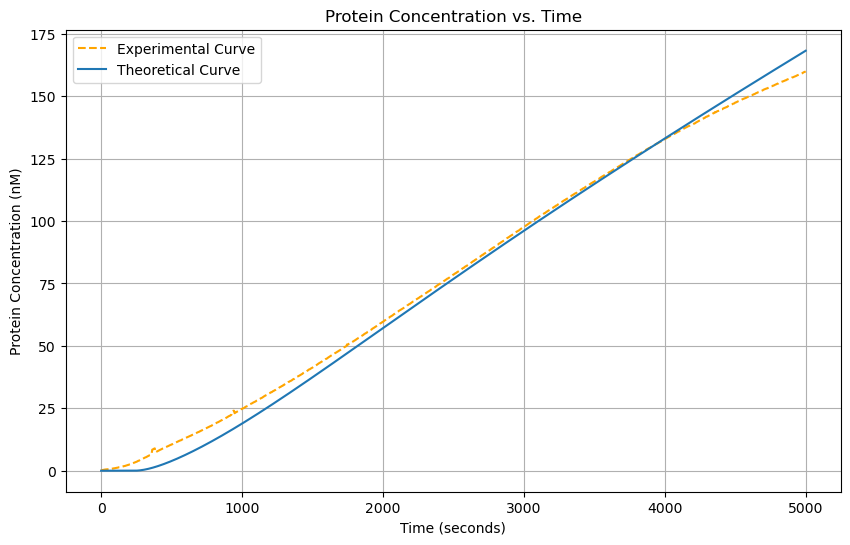

In [8]:
# -------- Example of theoretical curve for K401 motor protein --------

# ------------------------ Part 1 ------------------------

# These are the parameters of K401 for which we know the values of
N_p = 401 # We know the number of aminoacids, because we are analyzing the "k401" kinesin motor protein
N_m = 3000 # We also know the number of nucleotides 
D = 30 # We also know the DNA concentration

length = len(proteinConcentration_nM_List)
proteinConcentration_nM_List_NP = np.array(proteinConcentration_nM_List) # Important line: convert to NumPy array

subset_indices = np.linspace(0, length - 1, length, dtype=int) # Define indices: 0, 10, 20, 30, ..
subset_ProteinConcentration_nM_List = proteinConcentration_nM_List_NP[subset_indices] # Access the values locates in these indices

# Calculate the [R_p D] complex using the equation in the paper's supplementary information. 
def calculate_RpD(R_p, D, K_TX): # Accept parameters to calculate the [R_p D] complex
    discriminant = (R_p + D + K_TX)**2 - 4 * R_p * D
    if discriminant < 0:
        return 1e-6 # Return a small positive value if the discriminant is negative
    else:
        return 0.5 * (R_p + D + K_TX - np.sqrt(discriminant))

# Define the differential equation for protein concentration
def dPdt(T, P, Q, S, tau_0, tau_f, k3, k11): # Not only accept the variables T and P. Also, accept parameters that will be treated as constants in the ODE.
    if T > tau_0 + tau_f:
        return Q * (1 - np.exp(-(T - tau_0 - tau_f) / k3)) - (S * P) / (k11 + P)
    else:
        return 0 

def solve_ODE(params):

    k_TL, k_TX, R_p, tau_m, K_TL, R, k_deg, X_p, K_p, tau_0, tau_f = params # In Python, this is a way to define variables, given a list of values. Only 1 line is required

    RpD = calculate_RpD(R_p, D, k_TX) # For simplicity purposes, we calculated [R_p D] complex using a function
    Q = (k_TL * k_TX * RpD * tau_m) / (N_p * (1 + K_TL / R) * N_m)  
    S = k_deg * X_p
    k3 = tau_m
    k11 = K_p

    # Time ranges from T = 0 to T = 5000 seconds
    T = np.linspace(0, 5000, len(subset_ProteinConcentration_nM_List)) # Same size as the experimental data of the protein concentration

    P_initial = 0  # At t = 0, the protein concentration P(0) = 0

    # All of the constants such as Q, S, k3... need to be passed as arguments into the solve_ivp()function
    p = solve_ivp(dPdt, [T[0], T[-1]], [P_initial], t_eval=T, args=(Q, S, tau_0, tau_f, k3, k11), method ="LSODA") # Use the "LSODA" method to solve the ODE
    return p.y[0]

# The objective function uses the method of "Sum of Squared Errors (SSE)"
def objective_function(params):
    pModel = solve_ODE(params)
    return np.sum((subset_ProteinConcentration_nM_List-pModel)**2)

# 1st element: k_TL; 2nd element: k_TX; 3th element: R_p; 4th element: tau_m; 5th element: K_TL; 6th element: R; 7th element: k_deg; 8th element: X_p; 9th element: K_p; 10th element: tau_0, 11th element: tau_f
initial_guesses = [10, 1, 30, 720, 5, 190, 0.01, 9, 4, 0, 300] # The guesses are the same for ALL the motor proteins 
bounds = [(0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None)]

result = minimize(objective_function, initial_guesses, method='TNC', bounds=bounds) # "L-BFGS-B" is a popular method to minimize an objective function. "TNC" is another method to minimize an objective function
optimizedParameters = result.x #  Since "result" is an object, we need to access a certain attribute of "result" to extract the optimized parameters

def showOptimizedModel():

    # Print the optimized parameters
    print("Optimized parameters:")
    print("k_TL:", optimizedParameters[0])
    print("k_TX:", optimizedParameters[1])
    print("R_p:", optimizedParameters[2])
    print("tau_m:", optimizedParameters[3])
    print("K_TL:", optimizedParameters[4])
    print("R:", optimizedParameters[5])
    print("k_deg:", optimizedParameters[6])
    print("X_p:", optimizedParameters[7])
    print("K_p:", optimizedParameters[8])
    print("tau_0:", optimizedParameters[9])
    print("tau_f:", optimizedParameters[10])

    optimizedModel = solve_ODE(optimizedParameters)
    T = np.linspace(0, 5000, len(subset_ProteinConcentration_nM_List)) # Same size as the experimental data of the protein concentration
    plt.figure(figsize=(10, 6))  # Clear the figure before plotting
    plt.plot(T, subset_ProteinConcentration_nM_List, label='Experimental Curve', linestyle='--', color='orange')
    plt.plot(T, optimizedModel, label='Theoretical Curve') # We need to access the "y" values from the object that stores the solution to the ODE
    plt.title('Protein Concentration vs. Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Protein Concentration (nM)')
    plt.legend()
    plt.grid(True)
    plt.show()

showOptimizedModel()

In [16]:
# ------------------------ Part 2 ------------------------

# Calculate the [R_p D] complex using the equation in the paper's supplementary information. 
def calculate_RpD(R_p, D, K_TX): # Accept parameters to calculate the [R_p D] complex
    return 0.5 * (R_p + D + K_TX - np.sqrt((R_p + D + K_TX)**2 - 4 * R_p * D))

# Define the differential equation for protein concentration
def dPdt(T, P, Q, S, tau_0, tau_f, k3, k11): # Not only accept the variables T and P. Also, accept parameters that will be treated as constants in the ODE.
    if T > tau_0 + tau_f:
        return Q * (1 - np.exp(-(T - tau_0 - tau_f) / k3)) - (S * P) / (k11 + P)
    else:
        return 0 

# Create a function to plot the oscillators with given parameters
def plot_proteinConcentration(k_TL, k_TX, R_p, D, tau_m, N_p, K_TL, R, N_m, k_deg, X_p, K_p, tau_0, tau_f): #Parameters that will be able to be modified by the sliders
    
    RpD = calculate_RpD(R_p, D, k_TX) # For simplicity purposes, calculate [R_p D] complex using a function
    Q = (k_TL * k_TX * RpD * tau_m) / (N_p * (1 + K_TL / R) * N_m)  
    S = k_deg * X_p
    k3 = tau_m
    k11 = K_p

    # Time ranges from T = 0 to T = 5000 seconds
    T = np.linspace(0, 5000, len(subset_ProteinConcentration_nM_List)) # Same size as the experimental data of the protein concentration

    P_initial = 0  # At t = 0, the protein concentration P(0) = 0

    # All of the constants such as Q, S, tau_0... need to be passed as arguments into the solve_ivp()function
    p = solve_ivp(dPdt, [T[0], T[-1]], [P_initial], t_eval=T, args=(Q, S, tau_0, tau_f, k3, k11)) 
    
    plt.figure(figsize=(10, 6))  # Clear the figure before plotting
    plt.plot(T, subset_ProteinConcentration_nM_List, label='Experimental Curve', linestyle='--', color='orange')
    plt.plot(T, p.y[0], label='Theoretical Curve') # We need to access the "y" values from the object 'p' we created before
    plt.title('Protein Concentration vs. Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Protein Concentration (nM)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create interactive sliders for the parameters used to calculate the protein concentration

def showModel(optimizedParameters, N_p, N_m, D):

    k_TL, k_TX, R_p, tau_m, K_TL, R , k_deg, X_p, K_p, tau_0, tau_f = optimizedParameters

    # Create interactive sliders for the parameters used to calculate the protein concentration
    style = {'description_width': '300px'}  # Adjust the width as needed
    
    #k_TL, k_TX, R_p, tau_m, K_TL, R, k_deg, X_p, K_p, tau_0, tau_f = [56.93792378086880	14.366415252038600	220.73449708717800	1017.5903466928300	70.01552960356980	491.11094848471500	0.24184395053389100	425.48838967441200	73.10082325149290	6.8207329316351800	1283.1796880684800]
    interact(plot_proteinConcentration, 
           k_TL=FloatSlider(value=56.93792378086880 , min=0.0, max=100, step=0.1, description='k_TL (amino acids/s)', layout=Layout(width='1300px'), style=style, readout_format='.6f'),
            k_TX=FloatSlider(value=14.366415252038600 , min=0.0, max=100, step=0.1, description='k_TX (rNTP/s)', layout=Layout(width='1300px'), style=style, readout_format='.6f'),
            R_p=FloatSlider(value=220.73449708717800, min=0.0, max=500, step=0.1, description='RNA polymerase concentration (nM)', layout=Layout(width='1300px'), style=style, readout_format='.6f'), 
            D=FloatSlider(value=D, min=0.0, max=1000, step=1, description='DNA concentration (nM)', layout=Layout(width='1300px'), style=style, readout_format='.6f'), ## We know for sure the value of DNA concentration
            tau_m=FloatSlider(value=1017.5903466928300 , min=0.1, max=5000, step=0.1, description='mRNA lifetime (seconds)', layout=Layout(width='1300px'), style=style, readout_format='.6f'),
            N_p=FloatSlider(value=N_p, min=0.0, max=10000, step=1, description='protein length (amino acids)', layout=Layout(width='1300px'), style=style, readout_format='.6f'), ## We know for sure the number of aminoacids
            K_TL = FloatSlider(value=70.01552960356980, min=0.0, max=100, step=0.1, description='Michaelis-Menten constant for translation (nM)', layout=Layout(width='1300px'), style=style, readout_format='.6f'),
            R=FloatSlider(value=491.11094848471500, min=0.1, max=1e3, step=0.1, description='ribosome concentration (nM)', layout=Layout(width='1300px'), style=style, readout_format='.6f'), 
            N_m=FloatSlider(value=N_m, min=0.0, max=10000, step=1, description='mRNA Length (Nucleotides)', layout=Layout(width='1300px'), style=style, readout_format='.6f'), ## We know for sure the number of nucleotides (this is based on the DNA design)
            k_deg=FloatSlider(value=0.24184395053389100, min=0.0, max=100, step=0.01, description='protein degradation rate constant (1/s)', layout=Layout(width='1300px'), style=style, readout_format='.6f'), 
            X_p=FloatSlider(value=425.48838967441200, min=0.0, max=500, step=0.1, description='protease concentration (nM)', layout=Layout(width='1300px'), style=style, readout_format='.6f'), 
            K_p=FloatSlider(value=73.10082325149290, min=1e-6, max=100, step=0.01, description='Michaelis-Menten constant for degradation (nM)', layout=Layout(width='1300px'), style=style, readout_format='.6f'),
            tau_0=FloatSlider(value=6.8207329316351800, min=0.0, max=10, step=0.1, description='transcription delay (seconds)', layout=Layout(width='1300px'), style=style, readout_format='.6f'), 
            tau_f=FloatSlider(value=1283.1796880684800, min=0.0, max=2000, step=0.1, description='protein folding delay (seconds)', layout=Layout(width='1300px'), style=style, readout_format='.6f'))

showModel(optimizedParameters, N_p, N_m, D)

interactive(children=(FloatSlider(value=56.9379237808688, description='k_TL (amino acids/s)', layout=Layout(wi…

In [17]:
# ------------------------ Testing ------------------------

# These are the parameters of K401 for which we know the values of
N_p = 401 # We know the number of aminoacids, because we are analyzing the "k401" kinesin motor protein
N_m = 3000 # We also know the number of nucleotides 
D = 30 # We also know the DNA concentration

# Calculate the [R_p D] complex using the equation in the paper's supplementary information. 
def calculate_RpD(R_p, D, K_TX): # Accept parameters to calculate the [R_p D] complex
    return 0.5 * (R_p + D + K_TX - np.sqrt((R_p + D + K_TX)**2 - 4 * R_p * D))

# Define the differential equation for protein concentration
def dPdt(T, P, Q, S, tau_0, tau_f, k3, k11): # Not only accept the variables T and P. Also, accept parameters that will be treated as constants in the ODE.
    if T > tau_0 + tau_f:
        return Q * (1 - np.exp(-(T - tau_0 - tau_f) / k3)) - (S * P) / (k11 + P)
    else:
        return 0 

# Create a function to plot the oscillators with given parameters
def plot_proteinConcentration(): #Parameters that will be able to be modified by the sliders
    
    k_TL, k_TX, R_p, tau_m, K_TL, R, k_deg, X_p, K_p, tau_0, tau_f = [59.20000000109350, 31.600000001155000, 427.7200000196670, 3183.260001258780, 10.480000000010200, 149.4200000382540, 62.07000000042180, 95.310000012812, 93.24000000019500, 3.6700000000061900, 1585.510000247560]

    RpD = calculate_RpD(R_p, D, k_TX) # For simplicity purposes, calculate [R_p D] complex using a function
    Q = (k_TL * k_TX * RpD * tau_m) / (N_p * (1 + K_TL / R) * N_m)  
    S = k_deg * X_p
    k3 = tau_m
    k11 = K_p

    # Time ranges from T = 0 to T = 5000 seconds
    T = np.linspace(0, 5000, len(subset_ProteinConcentration_nM_List)) # Same size as the experimental data of the protein concentration

    P_initial = 0  # At t = 0, the protein concentration P(0) = 0

    # All of the constants such as Q, S, tau_0... need to be passed as arguments into the solve_ivp()function
    p = solve_ivp(dPdt, [T[0], T[-1]], [P_initial], t_eval=T, args=(Q, S, tau_0, tau_f, k3, k11)) 
    
    plt.figure(figsize=(10, 6))  # Clear the figure before plotting
    plt.plot(T, subset_ProteinConcentration_nM_List, label='Experimental Curve', linestyle='--', color='orange')
    plt.plot(T, p.y[0], label='Theoretical Curve') # We need to access the "y" values from the object 'p' we created before
    plt.title('Protein Concentration vs. Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Protein Concentration (nM)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create interactive sliders for the parameters used to calculate the protein concentration

def showModel():

    # Create interactive sliders for the parameters used to calculate the protein concentration
    style = {'description_width': '300px'}  # Adjust the width as needed
   
    interact(plot_proteinConcentration, 
           k_TL=FloatSlider(value=k_TL , min=0.0, max=100, step=0.1, description='k_TL (amino acids/s)', layout=Layout(width='900px'), style=style),
            k_TX=FloatSlider(value=k_TX , min=0.0, max=100, step=0.1, description='k_TX (rNTP/s)', layout=Layout(width='900px'), style=style),
            R_p=FloatSlider(value=R_p, min=0.0, max=500, step=0.1, description='RNA polymerase concentration (nM)', layout=Layout(width='900px'), style=style), 
            D=FloatSlider(value=D, min=0.0, max=1000, step=1, description='DNA concentration (nM)', layout=Layout(width='900px'), style=style), ## We know for sure the value of DNA concentration
            tau_m=FloatSlider(value=tau_m , min=0.1, max=5000, step=0.1, description='mRNA lifetime (seconds)', layout=Layout(width='900px'), style=style),
            N_p=FloatSlider(value=N_p, min=0.0, max=10000, step=1, description='protein length (amino acids)', layout=Layout(width='900px'), style=style), ## We know for sure the number of aminoacids
            K_TL = FloatSlider(value=K_TL, min=0.0, max=100, step=0.1, description='Michaelis-Menten constant for translation (nM)', layout=Layout(width='900px'), style=style),
            R=FloatSlider(value=R, min=0.1, max=1e3, step=0.1, description='ribosome concentration (nM)', layout=Layout(width='900px'), style=style), 
            N_m=FloatSlider(value=N_m, min=0.0, max=10000, step=1, description='mRNA Length (Nucleotides)', layout=Layout(width='900px'), style=style), ## We know for sure the number of nucleotides (this is based on the DNA design)
            k_deg=FloatSlider(value=k_deg, min=0.0, max=100, step=0.1, description='protein degradation rate constant (1/s)', layout=Layout(width='900px'), style=style), 
            X_p=FloatSlider(value=X_p, min=0.0, max=500, step=0.1, description='protease concentration (nM)', layout=Layout(width='900px'), style=style), 
            K_p=FloatSlider(value=K_p, min=0.01, max=100, step=0.01, description='Michaelis-Menten constant for degradation (nM)', layout=Layout(width='900px'), style=style),
            tau_0=FloatSlider(value=tau_0, min=0.0, max=10, step=0.1, description='transcription delay (seconds)', layout=Layout(width='900px'), style=style), 
            tau_f=FloatSlider(value=tau_f, min=0.0, max=2000, step=0.1, description='protein folding delay (seconds)', layout=Layout(width='900px'), style=style))

#showModel()